Loosely following:
 
https://www.datacamp.com/tutorial/fine-tuning-large-language-models

In [1]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, Gemma3Model
from huggingface_hub import login
from dotenv import load_dotenv
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/kuba/.virenv/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
MODEL = "google/gemma-3-4b-it"
SEED = 69

login(token=HUGGINGFACE_TOKEN)

In [3]:
# Lets get tha dataset
# For us the dataset will be 
raw_dataset = load_dataset("mteb/tweet_sentiment_extraction")
df_train = pd.DataFrame(raw_dataset['train'])
df_test = pd.DataFrame(raw_dataset['test'])

In [4]:
# each segment of text "tweet" has a class 0 (negative), 1 (neutral), or 2 (positive)
df_train['label'].unique()

array([1, 0, 2])

In [5]:
df_train

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
...,...,...,...,...
26727,4eac33d1c0,wish we could come see u on Denver husband l...,0,negative
26728,4f4c4fc327,I`ve wondered about rake to. The client has ...,0,negative
26729,f67aae2310,Yay good for both of you. Enjoy the break - y...,2,positive
26730,ed167662a5,But it was worth it ****.,2,positive


In [6]:
# we need this to format the input so model can understand
tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)

In [7]:
# test of the tokenizer
text = ['hello world', 'bobby like to eat pizza']
vec = tokenizer(text, padding=True)
print("encoding: ",vec)

print("decoding: ",tokenizer.batch_decode(vec['input_ids']))

encoding:  {'input_ids': [[0, 0, 0, 0, 2, 23391, 1902], [2, 236763, 13990, 1133, 531, 9039, 19406]], 'attention_mask': [[0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}
decoding:  ['<pad><pad><pad><pad><bos>hello world', '<bos>bobby like to eat pizza']


In [8]:
# we jsut define this so be used with the 'dataset' map function so apply to the data
def tokenize_dataset(data):
    return tokenizer(data['text'], padding="max_length", truncation=True, max_length=128)

In [9]:
# apply tokanizeion to the dataset
dataset = raw_dataset.map(tokenize_dataset, batched=True)

In [ ]:
# shuffle the dataset and split into smaller part so can run on laptop
train = dataset['train'].shuffle(SEED)
test = dataset['test'].shuffle(SEED)

In [39]:
#make data into a tensor
X_train = torch.tensor(train['input_ids'])
y_train = F.one_hot(torch.tensor(train['label']), num_classes=3).float()
X_test = torch.tensor(test['input_ids'])
y_test = F.one_hot(torch.tensor(test['label']), num_classes=3).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([4, 128]),
 torch.Size([4, 3]),
 torch.Size([4, 128]),
 torch.Size([4, 3]))

In [40]:
y_train

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [41]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

In [30]:
def check_gpu_memory():
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"\nGPU {i}:")
            print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
            print(f"  Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
            print(f"  Total: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")


In [31]:
# Since we are using gemma we need to add on to the base model a classification head
# To do so we will import the base model then construct our model using output from the base model
baseModel = Gemma3Model.from_pretrained(MODEL, device_map='auto', 
                                        output_hidden_states=True, 
                                        attn_implementation="eager", 
                                            max_memory = {
                                            0: "20GiB",        # GPU 0 - more memory training
                                            1: "8GiB",        # GPU 1 - less of the model since it will have outpus and y 
                                            "cpu": "80Gib"
                                            }
                                        )

check_gpu_memory()

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.



GPU 0:
  Allocated: 16.56 GB
  Cached: 16.64 GB
  Total: 23.65 GB

GPU 1:
  Allocated: 18.95 GB
  Cached: 19.05 GB
  Total: 23.65 GB


In [32]:
# We do this so that we have more room on the gpus
baseModel.vision_tower  = baseModel.vision_tower.to("cpu")
for param in baseModel.vision_tower.parameters():
                param.requires_grad = False
    
check_gpu_memory()


GPU 0:
  Allocated: 15.01 GB
  Cached: 16.64 GB
  Total: 23.65 GB

GPU 1:
  Allocated: 18.95 GB
  Cached: 19.05 GB
  Total: 23.65 GB


In [33]:
baseModel.config.output_hidden_states = True          
baseModel.gradient_checkpointing_enable()     

In [34]:
# this is were we define out custom model that use the base model as a back bone
class Gemma3Classifier(nn.Module):
    def __init__(self, bmodel, hiddensize, dropout=0.1):
        super().__init__()
        self.bmodel = bmodel
        self.dropout = nn.Dropout(dropout) 
        self.head = nn.Linear(hiddensize, 3).to('cuda:1')
        self.device_placement = True
    
    def forward(self, input_ids):
        out = self.bmodel(input_ids)
        hidden_state = out.hidden_states[-1]
        embeddings = hidden_state[:, -1, :]  

        embeddings = embeddings.to('cuda:1')

        logits = self.head(self.dropout(embeddings))

        return logits 

In [35]:
model = Gemma3Classifier(bmodel=baseModel, dropout=0.1, hiddensize=baseModel.config.text_config.hidden_size)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.head.parameters() ,lr=0.0003)

In [37]:
lossi = []
devlossi = []
torch.cuda.empty_cache()

In [42]:
for epoch in tqdm(range(10)):
    optimizer.zero_grad()

    loss_total = 0
    for X_train, y_train in train_loader:
        out = model(input_ids=X_train)
        y_train = y_train.to('cuda:1')
        loss = criterion(out, y_train)
        loss.backward()
        loss_total += loss.item()

    optimizer.step()
    lossi.append(loss_total / len(train_loader))
    torch.cuda.empty_cache()

    with torch.no_grad():
        dev_loss_total = 0
        for X_test, y_test in test_loader:
            out = model(input_ids=X_test)
            y_test = y_test.to('cuda:1')
            loss = criterion(out, y_test)
            loss_total += loss.item()

        devlossi.append(dev_loss_total / len(test_loader))




100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


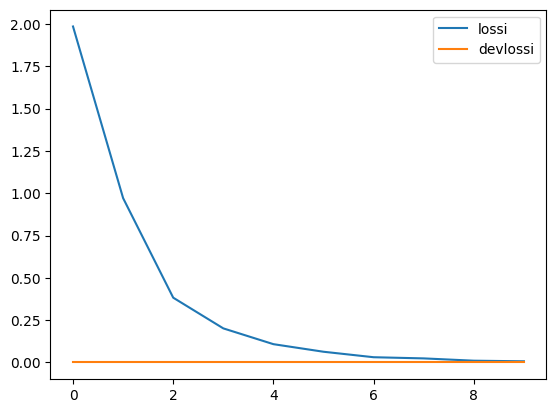

In [43]:
plt.plot(lossi, label="lossi")
plt.plot(devlossi, label="devlossi")
plt.legend()

In [ ]:
dataset

In [44]:
ex = dataset['train'][999]
ex_text = ex['text']
ex_input = torch.tensor(ex['input_ids']).unsqueeze(dim=0)
ex_label = ex['label']

with torch.no_grad():
    pred = model(ex_input)

print(f'The test is: {ex_text}')
print(f'The label is: {ex_label}')
print(f'The pred is: {torch.sigmoid(pred)}')

The test is: looked up weather for greece this weekend....80 and sunny OMGZ
The label is: 1
The pred is: tensor([[0.0108, 0.8889, 0.3932]], device='cuda:1')
